# Neural Network
Understanding the selectivity of kmers in phages, against bacteria targets\
Each phage has a confirmed binding to a bacteria. The kmers of the phage can therefore be denoted with True/False for binding to a bacteria.\
Using MinHash sketches, the kmers are compressed, while its uniqueness is still preserved.\
With MinHashed kmers however, we cant "go back" and extract which kmers were most important.

## Prepping data 


In [ ]:
import sourmash, os
from tqdm import tqdm
import pandas as pd
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
SKETCH_DIR = data_prod_path + "phage_minhash_18/"
K = 18 #kmer size; equal to 6 aa.

def binarize_host_range(host_range_dict):
    binary_dict = {}
    for host, val in host_range_dict.items():
        if pd.isna(val) or val == 0:
            binary_dict[host] = 0
        else:
            binary_dict[host] = 1
    return binary_dict

def short_species_name(full_name):
    if len(full_name.split(" ")) < 2:
        return full_name
    else:
        return full_name.split(" ")[0][0] + "." + full_name.split(" ")[1]

### Phage kmer data - MinHashed sketches

Prepping hostrange data

In [114]:
import pandas as pd

# Load the host range data from the Excel file
file_path = raw_data_path + "phagehost_KU/Hostrange_data_all_crisp_iso.xlsx"
sheet_name = "sum_hostrange"  # replace with your sheet name
host_range_df = pd.read_excel(
    file_path,
    sheet_name='sum_hostrange',
    header=1).drop(columns=["isolate ID", "Hostrange_analysis", "Phage"])

# Create a lookup dictionary for bacteria species based on Seq ID - dict
bact_lookup = host_range_df[["Seq ID", "Species"]].drop_duplicates(subset=['Seq ID']).set_index('Seq ID').to_dict()['Species']
print("Bacteria lookup dictionary created with", len(bact_lookup), "entries.")
print(bact_lookup)

# Make Seq ID to phage name mapping - pandas df
host_range_df = host_range_df.drop(columns=["Species"]).set_index('Seq ID').rename_axis('phage').reset_index()
display(host_range_df.head())

# Convert the host range data into a dictionary
host_range_data = {}
for index, row in host_range_df.iterrows():
    cleaned_index = row[1:].index.str.replace(" ", "")
    curr_bact_series = row[1:]
    curr_bact_series.index = cleaned_index
    host_range_data[row['phage']] = curr_bact_series.to_dict()

host_range_data["J10_21_reoriented"]

Bacteria lookup dictionary created with 110 entries.
{'J14_21_reoriented': 'Acinetobacter calcoaceticus', 'J53_21_reoriented': 'Acinetobacter calcoaceticus', 'J105_22_reoriented': 'Chishuiella', 'J46_21_reoriented': 'Chryseobacterium', 'J50_21_reoriented': 'Chryseobacterium', 'J2264_1_22_KMC_reoriented': 'Chryseobacterium', 'J2264_3_22_KMC_reoriented': 'Chryseobacterium', 'J63_22_reoriented': 'Chryseobacterium', 'J64_22_reoriented': 'Chryseobacterium', 'J1_21_reoriented': 'Lelliottia', 'J91_22_reoriented': 'Lelliottia', 'J51_21_reoriented': 'Morganella morganii', 'J57_21_reoriented': 'Morganella morganii', 'J10_21_reoriented': 'Pectobacterium atrosepticum', 'J11_21_reoriented': 'Pectobacterium atrosepticum', 'J126_23_reoriented': 'Pectobacterium atrosepticum', 'J12_21_reoriented': 'Pectobacterium atrosepticum', 'J16_21_reoriented': 'Pectobacterium atrosepticum', 'J22_21_reoriented': 'Pectobacterium atrosepticum', 'J28_21_reoriented': 'Pectobacterium atrosepticum', 'J33_21_reoriented': 

,phage,Ymer,Taid,Poppous,Koroua,Abuela,Amona,Sabo,Mimer,Crus,...,Vims,Echoes,Galvinrad,Uther,Rip,Rup,Slaad,Pantea,Rap,Zann
0,J14_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,J53_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,J105_22_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,J46_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,J50_21_reoriented,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


{'Ymer': nan,
 'Taid': nan,
 'Poppous': nan,
 'Koroua': nan,
 'Abuela': nan,
 'Amona': nan,
 'Sabo': nan,
 'Mimer': nan,
 'Crus': nan,
 'Gander': nan,
 'Guf': nan,
 'Hoejben': nan,
 'Magnum': 200000000,
 'Vims': nan,
 'Echoes': nan,
 'Galvinrad': nan,
 'Uther': nan,
 'Rip': nan,
 'Rup': nan,
 'Slaad': nan,
 'Pantea': nan,
 'Rap': nan,
 'Zann': nan}

In [ ]:
def binarize_host_range(host_range_dict):
    binary_dict = {}
    for host, val in host_range_dict.items():
        if pd.isna(val) or val == 0:
            binary_dict[host] = 0
        else:
            binary_dict[host] = 1
    return binary_dict

def short_species_name(full_name):
    if len(full_name.split(" ")) < 2:
        return full_name
    else:
        return full_name.split(" ")[0][0] + "." + full_name.split(" ")[1]

Loading MinHash sketches

In [120]:
from sourmash import load_one_signature
import shutil

parent_out_dir = data_prod_path + f"phage_minhash_{K}_txt/"
if not os.path.exists(parent_out_dir):
    os.makedirs(parent_out_dir)
else:
    shutil.rmtree(parent_out_dir)
    os.makedirs(parent_out_dir)

for selected_bact_species in set(bact_lookup.values()): 
    ### PREPPING HOST RANGE DATA ###
    # Select a specific bacteria species for host range analysis
    print(f"\nProcessing host range data for bacteria species: {selected_bact_species}")

    #obtain all the keys where the value is equal to selected_bact_species
    selected_seqIDs = [key for key, value in bact_lookup.items() if value == selected_bact_species]
    print("Seq IDs for selected species:", selected_seqIDs)

    # Acceptive approach: since all seqIDs for the same species should have similar host ranges, we combine their host range data.
    # if non-zero is found for any seqID, we set it to 1 in the final host range data.
    def combine_host_ranges(seqID_list, approach="acceptive", threshold=0.5, TS = False):
        combined_host_range = {}
        # Acceptive approach: if any seqID has a non-zero value for a host, set to 1
        if approach == "acceptive":
            for seqID in seqID_list:
                curr_host_range = binarize_host_range(host_range_data[seqID])
                for host, val in curr_host_range.items():
                    if host not in combined_host_range:
                        combined_host_range[host] = val
                    else:
                        if not pd.isna(val) and val != 0:
                            combined_host_range[host] = 1
            return combined_host_range
        
        # Count occurrences of non-zero values for each host, if higher than threshold, set to 1
        elif approach == "consensus":
            host_counts = {}
            for seqID in seqID_list:
                curr_host_range = binarize_host_range(host_range_data[seqID])
                for host, val in curr_host_range.items():
                    if host not in host_counts:
                        host_counts[host] = 0
                    if not pd.isna(val) and val != 0:
                        host_counts[host] += 1
            for host, count in host_counts.items():
                if TS: print(f"Host: {host}, Count: {count}, Total SeqIDs: {len(seqID_list)}, Ratio: {count / len(seqID_list)}")
                if count / len(seqID_list) >= threshold:
                    combined_host_range[host] = 1
                else:
                    combined_host_range[host] = 0
            return combined_host_range

    combined_host_range = combine_host_ranges(selected_seqIDs, approach="acceptive")
    print("Combined host range data for selected species:", combined_host_range)

    ### LOADING MINHASH SKETCHES ###
    minhash_data = {}
    print(f"\nLoading sketches from: {SKETCH_DIR}")
    for filename in os.listdir(SKETCH_DIR):
        if filename.endswith(('.sig', '.json')): # sourmash signature files
            filepath = os.path.join(SKETCH_DIR, filename)
            try:
                # sourmash.load_signatures returns an iterator
                sig = load_one_signature(filepath, K)
                
                if not sig:
                    print(f"Warning: No signatures found in {filename}. Skipping.")
                    continue

                phage_name = str(sig)
                
                if phage_name in combined_host_range:
                    # Extract the hash values (sorted for consistency)
                    hashes = sorted(sig.minhash.hashes.keys())
                    minhash_data[phage_name] = hashes
                else:
                    print(f"Warning: Sketch for {phage_name} found, but no matching entry in host range data. Skipping.")
                
            except Exception as e:
                print(f"Error loading sketch file {filename}: {e}. Skipping.")

    print(f"Loaded sketches for {len(minhash_data)} phages.")

    ### OUTPUTTING MINHASH TXT FILES ###
    out_dir = parent_out_dir + f"{str(selected_bact_species).replace(' ', '_')}/"
    if not os.path.exists(out_dir):
        os.makedirs(out_dir)

    for phage_name in minhash_data.keys():
        print(f"Phage: {phage_name}, Number of hashes: {len(minhash_data[phage_name])}")
        print(f"Writing {out_dir}+{phage_name}_{short_species_name(selected_bact_species)}...")
        with open(os.path.join(out_dir, f"{phage_name}.txt"), 'w') as f:
            for hash_value in minhash_data[phage_name]:
                f.write(f"{hash_value}\t{combined_host_range[phage_name]}\n")


Processing host range data for bacteria species: Pseudomonas marginalis
Seq IDs for selected species: ['J101_22_reoriented']
Combined host range data for selected species: {'Ymer': 0, 'Taid': 0, 'Poppous': 0, 'Koroua': 0, 'Abuela': 0, 'Amona': 0, 'Sabo': 0, 'Mimer': 0, 'Crus': 0, 'Gander': 0, 'Guf': 0, 'Hoejben': 0, 'Magnum': 0, 'Vims': 0, 'Echoes': 0, 'Galvinrad': 0, 'Uther': 0, 'Rip': 0, 'Rup': 0, 'Slaad': 0, 'Pantea': 0, 'Rap': 0, 'Zann': 0}

Loading sketches from: ../data_prod/phage_minhash_18/
Loaded sketches for 23 phages.
Phage: Uther, Number of hashes: 43728
Writing ../data_prod/phage_minhash_18_txt/Pseudomonas_marginalis/+Uther_P.marginalis...
Phage: Echoes, Number of hashes: 59620
Writing ../data_prod/phage_minhash_18_txt/Pseudomonas_marginalis/+Echoes_P.marginalis...
Phage: Gander, Number of hashes: 43574
Writing ../data_prod/phage_minhash_18_txt/Pseudomonas_marginalis/+Gander_P.marginalis...
Phage: Ymer, Number of hashes: 41205
Writing ../data_prod/phage_minhash_18_txt/Pse

### Make combined txt files per bacteria
each file will contain which minhashes has been in a phage that could infect the bacteria.

In [126]:
import random
### Concatenate all phage minhash txt files into a single file for easier NN training ###
all_phage_minhash_txt_path = data_prod_path + f"phage_minhash_{K}_combined/"
if not os.path.exists(all_phage_minhash_txt_path):
    os.makedirs(all_phage_minhash_txt_path)

for filename in os.listdir(parent_out_dir):
    if os.path.isdir(os.path.join(parent_out_dir, filename)):
        bact_folder = os.path.join(parent_out_dir, filename)
        combined_output_file = os.path.join(all_phage_minhash_txt_path, f"{filename}_combined.txt")
        with open(combined_output_file, 'w') as outfile:
            for phage_file in os.listdir(bact_folder):
                if phage_file.endswith('.txt'):
                    phage_filepath = os.path.join(bact_folder, phage_file)
                    with open(phage_filepath, 'r') as infile:
                        shutil.copyfileobj(infile, outfile)
        print(f"Combined sketches for {filename} into {combined_output_file}")
        
        print("Shuffling combined file for random distribution...")
        with open(combined_output_file, 'r') as f:
            lines = f.readlines()
        random.shuffle(lines)
        with open(combined_output_file, 'w') as f:
            f.writelines(lines)

Combined sketches for Chryseobacterium into ../data_prod/phage_minhash_18_combined/Chryseobacterium_combined.txt
Shuffling combined file for random distribution...
Combined sketches for Lelliottia into ../data_prod/phage_minhash_18_combined/Lelliottia_combined.txt
Shuffling combined file for random distribution...
Combined sketches for Acinetobacter_calcoaceticus into ../data_prod/phage_minhash_18_combined/Acinetobacter_calcoaceticus_combined.txt
Shuffling combined file for random distribution...
Combined sketches for Chishuiella into ../data_prod/phage_minhash_18_combined/Chishuiella_combined.txt
Shuffling combined file for random distribution...
Combined sketches for Vagococcus into ../data_prod/phage_minhash_18_combined/Vagococcus_combined.txt
Shuffling combined file for random distribution...
Combined sketches for Pectobacterium_polaris into ../data_prod/phage_minhash_18_combined/Pectobacterium_polaris_combined.txt
Shuffling combined file for random distribution...
Combined sketche

## Running NN

Inits

In [149]:
### Packages -----------------------------
import random
import numpy as np
import shutil

### Paths --------------------------------
raw_data_path = "../raw_data/"
data_prod_path = "../data_prod/"
NN_files_path = data_prod_path + "NN_files/"
if not os.path.exists(NN_files_path):
    os.makedirs(NN_files_path)
else:
    shutil.rmtree(NN_files_path)
    os.makedirs(NN_files_path)

### Custom variables ---------------------
K = 18 #kmer size; equal to 6 aa.
selected_bact_species = "Pectobacterium brasiliense" 
full_path = data_prod_path+f"phage_minhash_{K}_combined/{selected_bact_species.replace(' ', '_')}_combined.txt"
if not os.path.exists(full_path):
    raise FileNotFoundError("Combined minhash txt file for the selected bacteria species not found. Please run the data preparation steps first.")

### Splitting data
each folder in phage_minhash_K_txt is a bacteria name, specifying whether the sketches of each underlying phage txt file, can infect it.

In [150]:
def separate_test(input_file, train_val_ratio=0.9, test_ratio=0.1, TS = False) -> tuple:
    """
    Separate the input file into training/validation and test sets based on specified ratios.
    Write the separated data to respective train_val and test files.
    Returns the paths to the train_val and test files.
    """
    if TS: print(f"Separating data from {input_file} into train/val and test sets...")
    if abs(train_val_ratio + test_ratio - 1.0) > 1e-6:
        raise ValueError("Train, validation, and test ratios must sum to 1.")

    with open(input_file, 'r') as f:
        lines = f.readlines()

    random.shuffle(lines)

    total_lines = len(lines)
    train_val_end = int(total_lines * train_val_ratio)

    train_data = lines[:train_val_end]
    test_data = lines[train_val_end:]
    
    if TS: 
        print(f"Total lines: {total_lines}, Train/Val lines: {len(train_data)}, Test lines: {len(test_data)}")
        print(f"Ratios - Train/Val: {len(train_data)/total_lines:.2f}, Test: {len(test_data)/total_lines:.2f}", end="\n\n")

    # Write the separated data to respective files to save memory
    train_val_path = NN_files_path + f"{selected_bact_species.replace(' ', '_')}_train_val.txt"
    with open(NN_files_path + f"{selected_bact_species.replace(' ', '_')}_train_val.txt", 'w') as f:
        f.writelines(train_data)
    
    test_path = NN_files_path + f"{selected_bact_species.replace(' ', '_')}_test.txt"
    with open(NN_files_path + f"{selected_bact_species.replace(' ', '_')}_test.txt", 'w') as f:
        f.writelines(test_data)
    
    return train_val_path, test_path


def k_fold_split(train_val_file, k=5, seed=42):
    """
    Perform k-fold cross-validation split on the input file.
    Returns a list of (train_data, val_data) tuples for each fold.
    Does not return test data.
    """
    # Read all the shuffled train val data
    with open(train_val_file, 'r') as f:
        lines = f.readlines()

    # Compute fold sizes
    total = len(lines)
    fold_size = total // k
    folds = [lines[i*fold_size:(i+1)*fold_size] for i in range(k)]

    # Handle remainder lines (if not evenly divisible)
    remainder = lines[k*fold_size:]
    for i, line in enumerate(remainder):
        folds[i % k].append(line)

    # Generate (train, val) pairs
    all_folds = []
    for i in range(k):
        val_data = folds[i]
        train_data = [line for j, f in enumerate(folds) if j != i for line in f]
        all_folds.append((train_data, val_data))
    
    return all_folds

In [151]:
train_path, test_path = separate_test(full_path, train_val_ratio=0.9, test_ratio=0.1, TS=True)
print(f"Training/Validation data saved to: {train_path}")
print(f"Test data saved to: {test_path}")

Separating data from ../data_prod/phage_minhash_18_combined/Pectobacterium_brasiliense_combined.txt into train/val and test sets...
Total lines: 1145416, Train/Val lines: 1030874, Test lines: 114542
Ratios - Train/Val: 0.90, Test: 0.10

Training/Validation data saved to: ../data_prod/NN_files/Pectobacterium_brasiliense_train_val.txt
Test data saved to: ../data_prod/NN_files/Pectobacterium_brasiliense_test.txt


In [ ]:
#Purely to define split, no writing
k_fold_data = k_fold_split(train_path, k=5, seed=42)
for fold_idx, (train_data, val_data) in enumerate(k_fold_data):
    print(f"Fold {fold_idx+1}: Train data length: {len(train_data)}, Val data length: {len(val_data)}")

Fold 1: Train data length: 824699, Val data length: 206175
Fold 2: Train data length: 824699, Val data length: 206175
Fold 3: Train data length: 824699, Val data length: 206175
Fold 4: Train data length: 824699, Val data length: 206175
Fold 5: Train data length: 824700, Val data length: 206174


### Defining NN class

In [153]:
# Weights initialization function.
def xavier_initialization_normal(input_dim, output_dim):
    shape = (input_dim, output_dim)
    stddev = np.sqrt(2 / (input_dim + output_dim))
    return np.random.normal(0, stddev, size=shape) * 0.1

def random_initialization_normal(input_dim, output_dim):
    return np.random.randn(input_dim, output_dim) * 0.1

In [154]:
class SimpleFFNN:
    def __init__(self, input_size, hidden_size, output_size, initialization_function=xavier_initialization_normal):
        # Initialize weights and biases with small random values
        # initialization_function(input_dim, output_dim) -> np.array of shape (input_dim, output_dim)
        self.W1 = initialization_function(input_size, hidden_size)
        self.b1 = np.zeros(hidden_size)
        self.W2 = initialization_function(hidden_size, output_size)
        self.b2 = np.zeros(output_size)
        print(f'Input -> Hidden Layer Weight Matrix Shape: {self.W1.shape}',
              f'First Layer Bias Weights Vector Shape: {self.b1.shape}',
              f'Hidden -> Output layer Weight Matrix Shape: {self.W2.shape}',
              f'Second Layer Bias Weights Vector Shape: {self.b2.shape}', sep="\n")
        
    def relu(self, x):
        return np.maximum(0, x)

    def sigmoid(self, x): 
        """
        The normal version of sigmoid 1 / (1 + np.exp(-x)) is NOT numerically stable
        Here we split the case into two for positive and negative inputs
        because np.exp(-x) for something negative will quickly overflow if x is a large negative number
        """
        # This is equivalent to : 
        # if x>=0, then compute (1/(1+np.exp(-x)))
        # if x<0: compute (np.exp(x)/(1+np.exp(x))))
        return np.where(x >= 0, 1 / (1 + np.exp(-x)), 
                        np.exp(x) / (1 + np.exp(x)))

    def forward(self, x):
        """
        x:
        zi denotes the output of a hidden layer i
        ai denotes the output of an activation function (non-linearity) at layer i
        (activations are relu, sigmoid, tanh, etc.)
        Use self.function to call a method. for example: self.relu(XX)
        """

        # First layer : Use a relu here for the activation 
        z1 = np.dot(x, self.W1) + self.b1 #XX
        a1 = self.relu(z1) #XX
        
        # Output layer : Use a sigmoid here for the activation
        z2 = np.dot(a1, self.W2) + self.b2 #XX
        a2 = self.sigmoid(z2) #XX
        
        # Return all the intermediate outputs as well because we need them for backpropagation (see slides)
        return z1, a1, z2, a2

def relu_derivative(a):
    return np.where(a > 0, 1, 0)

def sigmoid_derivative(a):
    """
    For this derivative, it is not necessary to find a numerically stable version.
    Just take the base formula and derive it.    
    """
    return np.array(a*(1 - a))


def backward(net, x, y, z1, a1, z2, a2, learning_rate=0.01):
    """
    Function to backpropagate the gradients from the output to update the weights.
    Apply the chain rule and slowly work out the chain derivatives from the output back to the input
    Reminder that np.dot(array_1, array_2) and array.T exists to transpose an array for matrix multiplication
    """
    # This assumes that we are computing a MSE as the loss function.
    # Look at your slides to compute the gradient backpropagation for a mean-squared error using the chain rule.

    # Output layer error ; We used a sigmoid in this layer
    dE_dO = a2 - y
    dO_do = sigmoid_derivative(a2)
    dE_do = dE_dO * dO_do

    #print("dE_do", dE_do.shape)
    ### (REMEMBER for np.dot(A,B) columns of A MUST equal rows in B) ###
    
    # Backpropagate to hidden layer 
    #print("a1", a1.shape)
    dE_dW2 = np.dot(dE_do.T, a1)
    dE_db2 = np.sum(dE_do, axis=0, keepdims=True)
    dE_db2 = dE_db2.squeeze() # Squeeze is needed here to make the dimensions fit
    #print("dE_dW2", dE_dW2.shape)
    #print("dE_db2", dE_dW2.shape)

    # Hidden layer error ; We used a ReLU in this layer!
    # (O − t)⋅ g'(o)⋅wj
    dE_dH = np.dot(dE_do, net.W2.T)
    #print("dE_dH", dE_dH.shape)
    dE_dh = dE_dH * relu_derivative(a1)
    #print("dE_dh", dE_dh.shape)

    # Backpropagate to input layer
    dE_dW1 = np.dot(dE_dh.T, x)
    #print("dE_dh", dE_dh.shape)
    dE_db1 = np.sum(dE_dh, axis=0, keepdims=True) 
    dE_db1 = dE_db1.squeeze() # Squeeze is needed here to make the dimensions fit
    #print("dE_db1", dE_db1.shape)

    # Update weights and biases using gradient descent
    net.W1 -= learning_rate * dE_dW1.T
    #print("W1 shapes:", net.W1.shape, dE_dW1.T.shape)
    net.b1 -= learning_rate * dE_db1.T
    #print("b1 shapes:", net.b1.shape, dE_db1.T.shape)
    net.W2 -= learning_rate * dE_dW2.T
    #print("W2 shapes:", net.W2.shape, dE_dW2.T.shape)
    net.b2 -= learning_rate * dE_db2.T
    #print("b2 shapes:", net.b2.shape, dE_db2.T.shape)

    

### Train & Validate model
an encoder function is needed to parse my train and val data, in order to perform 2 crucial steps:
1. Fixing Sequence Length (Padding and Truncation)
2. Creating the 3D Tensor Structure; $$(\text{Batch Size}, \text{Sequence Length}, \text{Feature Dimensions})$$

### Testing model

# Model using Keras

In [ ]:
import os
import pandas as pd

K = 18
data_prod_path = "../data_prod/"
all_phage_minhash_txt_path = data_prod_path + f"phage_minhash_{K}_combined/"

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file in the directory
for filename in os.listdir(all_phage_minhash_txt_path):
    if filename.endswith('_combined.txt'):
        filepath = os.path.join(all_phage_minhash_txt_path, filename)
        
        # Read the file into a dataframe
        df = pd.read_csv(filepath, sep='\t', header=None, names=['kmer_hash', 'label'])
        
        # Append the dataframe to the list
        dfs.append(df)

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs, ignore_index=True)
combined_df.to_csv(all_phage_minhash_txt_path+"../phage_18_all.txt", sep="\t")

print(f"Combined dataframe shape: {combined_df.shape}")
print(combined_df.head())

Combined dataframe shape: (18326656, 2)
              kmer_hash  label
0   7378849949655349661      0
1   3805812362527107331      0
2  14716982868510121616      1
3  14862428582876598283      0
4    562542509448007747      0


In [25]:
### Combining files that starts with Pectobacterium
import os
import pandas as pd

K = 18
data_prod_path = "../data_prod/"
all_phage_minhash_txt_path = data_prod_path + f"phage_minhash_{K}_combined/"

# Initialize an empty list to store dataframes
dfs = []

# Loop through each file in the directory
for filename in os.listdir(all_phage_minhash_txt_path):
    if filename.startswith('Pecto'):
        filepath = os.path.join(all_phage_minhash_txt_path, filename)
        
        # Read the file into a dataframe
        df = pd.read_csv(filepath, sep='\t', header=None, names=['kmer_hash', 'label'])
        
        # Append the dataframe to the list
        dfs.append(df)

# Concatenate all dataframes into a single dataframe
pecto_df = pd.concat(dfs, ignore_index=True)
pecto_df.to_csv(all_phage_minhash_txt_path+"../phage_18_pecto.txt", sep="\t")

print(f"pecto_df dataframe shape: {pecto_df.shape}")
print(pecto_df.head())

pecto_df dataframe shape: (6872496, 2)
              kmer_hash  label
0   7378849949655349661      0
1   3805812362527107331      0
2  14716982868510121616      1
3  14862428582876598283      0
4    562542509448007747      0


In [26]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

K = 18
selected_bact_species = "Pectobacterium brasiliense"
data_prod_path = "../data_prod/"
full_path = data_prod_path+f"phage_minhash_{K}_combined/{selected_bact_species.replace(' ', '_')}_combined.txt"
# --- 1. Raw Data Input ---
# The provided data of minhashed k-mers and their binary labels (0/1).
data_str = """
14104189032391025891	0
9272555873177485702	1
14099220935155194787	0
14904868568718467447	0
4598318341245526010	0
12928218682532402448	0
17766489500413828799	0
12262843827502767463	1
15191645544529172491	0
10259680472464355762	1
18329537351721549328	0
1168172853346433374	1
2081507574639483341	1
15806857621905048525	1
13505998584889076293	1
683483166365466956	0
"""

# Read the data into a DataFrame
#df = pd.read_csv(full_path, sep='\t', header=None, names=['kmer_hash', 'label'])
#df = combined_df
df = pecto_df

# Separate the single numerical feature (X) and the binary labels (y)
X = df[['kmer_hash']].values
y = df['label'].values

print(f"Total samples: {len(X)}")
print("-" * 50)


# --- 2. Data Splitting (60/20/20 for Train/Validation/Test) ---

# Step 1: Split into Training (50%) and Temporary (50%) sets
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, 
    test_size=0.5,  
    random_state=42, 
    shuffle=True, 
    stratify=y       # Important for small datasets to keep class balance
)

# Step 2: Split Temporary (50%) into Validation (25%) and Testing (25%) sets
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, 
    test_size=0.5,
    random_state=42,
    stratify=y_temp
)

print(f"Split completed: Train={len(X_train)}, Validation={len(X_val)}, Test={len(X_test)}")
print("-" * 50)

# --- 3. Preprocessing: Feature Scaling (MANDATORY for large integers) ---
# We use StandardScaler to normalize the huge hash values to have zero mean and unit variance.

scaler = StandardScaler()

# Fit the scaler ONLY on the training data to prevent data leakage
X_train_scaled = scaler.fit_transform(X_train)
# Transform the validation and test sets using the training data's parameters
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print("Feature Scaling complete. Data is ready for the network.")
# Example of scaled values (will be close to zero)
print(f"Example scaled k-mer value: {X_train_scaled[0][0]:.4f}")
print("-" * 50)


# --- 4. Define the Neural Network Model ---
# A simple feedforward network for binary classification.

def build_classifier_model():
    model = Sequential([
        # Input layer expects a single feature (the scaled hash value)
        Dense(32, activation='relu', input_shape=(1,), name='Input_Layer'), 
        # Hidden layer 1
        Dense(16, activation='relu', name='Hidden_Layer_1'),
        # Output layer for binary classification: 1 unit with sigmoid activation
        Dense(1, activation='sigmoid', name='Output_Layer') 
    ])
    
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy', # Standard loss for binary output
        metrics=['accuracy']
    )
    return model

model = build_classifier_model()
model.summary()
print("-" * 50)

# --- 5. Train and Evaluate ---

print("Starting model training (100 Epochs)...")

model.fit(
    X_train_scaled, 
    y_train, 
    epochs=2,           
    batch_size=4,         
    validation_data=(X_val_scaled, y_val),
    verbose=1             # Keep the output clean
)

# Evaluate on the final, unseen test set
loss, accuracy = model.evaluate(X_test_scaled, y_test, verbose=0)

print(f"Training Complete.")
print(f"Test Accuracy on unseen data: {accuracy:.4f}")
print("-" * 50)


Total samples: 6872496
--------------------------------------------------
Split completed: Train=3436248, Validation=1718124, Test=1718124
--------------------------------------------------
Feature Scaling complete. Data is ready for the network.
Example scaled k-mer value: 0.4242
--------------------------------------------------


/Users/asbjornhansen/Library/Python/3.9/lib/python/site-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input_Layer (Dense)             │ (None, 32)             │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Hidden_Layer_1 (Dense)          │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Output_Layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 609 (2.38 KB)

 Trainable params: 609 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

--------------------------------------------------
Starting model training (100 Epochs)...
Epoch 1/2
859062/859062 ━━━━━━━━━━━━━━━━━━━━ 428s 498us/step - accuracy: 0.5788 - loss: 0.6811 - val_accuracy: 0.5789 - val_loss: 0.6798
Epoch 2/2
859062/859062 ━━━━━━━━━━━━━━━━━━━━ 427s 497us/step - accuracy: 0.5791 - loss: 0.6808 - val_accuracy: 0.5789 - val_loss: 0.6809
Training Complete.
Test Accuracy on unseen data: 0.5789
--------------------------------------------------


53692/53692 ━━━━━━━━━━━━━━━━━━━━ 12s 231us/step
ROC AUC Score: 0.5000
--------------------------------------------------


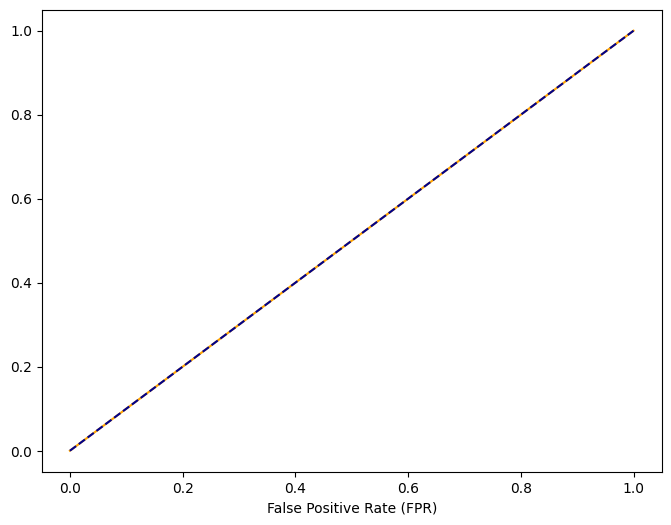

In [27]:
# --- 6. ROC Curve Analysis and Plotting (NEW SECTION) ---
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, roc_auc_score 

# Predict probabilities on the test set
# .ravel() converts the (n, 1) prediction array to a (n,) vector
y_pred_proba = model.predict(X_test_scaled).ravel()

# Calculate ROC curve metrics (False Positive Rate, True Positive Rate, and Thresholds)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Calculate the Area Under the Curve (AUC)
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f"ROC AUC Score: {roc_auc:.4f}")
print("-" * 50)

# Plot the ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='orange', label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--', label='Random Classifier (AUC = 0.50)')
plt.xlabel('False Positive Rate (FPR)')
plt.savefig("ROC_curve.png")

In [28]:
thresholds

array([       inf, 0.42811233], dtype=float32)